## CT5133 / CT5145 Deep Learning (/Online) 2023-2024 (Part 2, James McDermott)

## Assignment 2

* Student ID(s): YOUR ID HERE [22239157] 
* Student name(s): YOUR NAME HERE [Krishan D Radadia]

* Student ID(s): YOUR ID HERE [23110708] 
* Student name(s): YOUR NAME HERE [Sambit Bal]



In this assignment, we'll create an image classifier, inspect the embeddings it produces, try out different hyperparameters, and compare to a pretrained model.

### Due date

As announced on Canvas.

### Weighting

20% of the module.

### Tasks

1. Load and preprocess the `CIFAR-10` dataset using the supplied code.
2. Create a small convolutional model for classifying this dataset. Use a final `Dense(10)` layer for classification. Before that, use a `Dense(z)` layer, where `z` is a hyperparameter with value `z=2` for now.
3. Train the model and report performance. Ensure the training log is visible in the notebook. By looking at the training loss and validation loss, decide how many epochs are needed.
4. Visualise the output of the penultimate `Dense(z)` layer, on a subset of test data. One approach could use the supplied `visualise_embedding` function.
5. Repeat Steps 3-4 for some variants of the network: try `z=2` and `z=10`, and try some changes in architecture such as using different kernel parameters, more or different layers, or a different optimiser. And/or try using different fractions of the data during training.
6. Load a pretrained model, freeze it, discard its classification head, and add a new classification head suitable for the task. Again repeat Steps 3-4 for this network (choosing a suitable layer for visualisation, which can again be a `Dense(2)`, if you like). (You don't need to repeat Step 5 for this network.) Note: if the pretrained model does not like the CIFAR-10 image size (32x32), code for resizing images is supplied.
7. For each model you created, and for the pretrained model, comment (using Markdown cells in the notebook) on the differences in the embedding: how many dimensions are there, and why? Ignoring classes, what distribution of data do you observe and why? Now focussing on classes, what do you observe? Which embeddings are better? Relate this to performance of the classifier in each case. This part must be written in your own words. 


### Grading

1. 0 marks. 
2. 3 marks for a conv model with no conceptual errors, with a Dense(2) layer. Partial marks: 1 mark for any model that compiles ok.
3. 2 marks for a successful training log, with epochs chosen based on correct reasoning with the loss values. Partial marks: 1 mark for any training log.
4. 0 marks.
5. 5 marks for trying multiple sensible variations, well-organised. Partial marks: 2 marks if only 1-2 variations, or they are not sensible (eg, they reveal a misunderstanding of what different layers do). 1 mark for some attempt at variation leading to a different training log, versus (3).
6. 4 marks. 1 for loading and freezing and discarding head. 2 for appropriate design of classification head and 1 for training. 1 for visualisation.
7. 6 marks. Full marks for answers to all, demonstrating understanding of all issues. Guideline: 1 sentence for each answer, for each model, is likely sufficient. Partial marks: 3 marks for giving observations without understanding of what would be desirable properties in embeddings, or relation to classifier performance.

Marks will be subtracted for issues such as existing code used without attribution, or generative AI used without attribution.

Total: 20 marks



### Some rules

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras using the Tensorflow or PyTorch backend, or in PyTorch itself.

* **Generative AI** can be used to generate the code for this assignment. Every piece of generated material must be individually and clearly marked and attributed to a specific model, with a URL linking to the model, and must include the prompt(s) used, and a comment on why you chose to use Generative AI for this particular task or problem. The student is still required to understand all details of their own submission. Low grades will be awarded where it is clear generative AI has been used without attribution. When commenting on the embeddings, you must look at the embedding with your own eyes and comment on it yourself, in your own words. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code from the internet, **if you provide a citation with URL for each specific part**. A set of references at the bottom of the notebook is not sufficient.

* **Submission**: after completing your work in this Jupyter notebook, submit your notebook on Canvas in `.ipynb` format.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.

### Some code is provided:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from keras.layers import Resizing
from keras.datasets import cifar10
from keras.utils import to_categorical, set_random_seed
import keras

In [2]:
# remove this cell before posting
from keras.applications import MobileNetV2
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, BatchNormalization, Activation, Dropout

In [3]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/
    
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
set_random_seed(0)

In [4]:
def subsample(X, y=None, p=0.1):
    # work with a fraction of the data
    n_samples = X.shape[0]
    subsample_size = int(n_samples * p)
    idxs = np.random.choice(n_samples, subsample_size, replace=False)
    if y is None:
        return X[idxs]
    else:
        return X[idxs], y[idxs]        

def visualise_embedding(X, y=None, p_subsample=None):
    """
    Visualise an embedding X as a scatterplot.
    
    Optionally visualise class labels y at the same time as colours.
    
    If X has >2 dimensions, use UMAP to reduce to 2.
    
    User can supply eg subsample=0.01, to show a small fraction of the data.
    """
    n_samples, n_features = X.shape

    # check X and y shapes compatible
    if y is not None:
        if n_samples != y.shape[0]: 
            raise ValueError(f"X and y have incompatible shapes {X.shape} and {y.shape}")
            
        if len(y.shape) == 2:
            # these are probably one-hot encoded, so convert to integer
            y = np.argmax(y, axis=1)

    # work with only a fraction of the data
    if p_subsample is not None:
        if y is None: 
            X = subsample(X, p_subsample)
        else:
            X, y = subsample(X, y, p_subsample)

    # ensure we have 2 dimensions, using UMAP for dim reduction if needed
    if n_features > 2:
        import umap # pip install umap-learn
        reducer = umap.UMAP()
        X = StandardScaler().fit_transform(X) # need all dimensions to be on approx same scale
        X = reducer.fit_transform(X) # UMAP reduce to 2D
        
    # Visualization
    colors = plt.get_cmap('tab10')  # Get a color map with 10 distinct colors

    plt.figure(figsize=(10, 8))
    for i in range(10): # for 10 classes in CIFAR-10
        indices = np.where(y == i)
        plt.scatter(X[indices, 0], X[indices, 1], label=f'Class {i}', color=colors(i))

    # reflect the dim reduction in axis labels if needed
    if n_features == 2:
        axis0_lab = "z0"
        axis1_lab = "z1"
    else:
        axis0_lab = "UMAP0"
        axis1_lab = "UMAP1"
                
    plt.legend()
    plt.xlabel(axis0_lab)
    plt.ylabel(axis1_lab)
    plt.show()    

In [5]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [6]:
# keep only a small amount of the training data for fast prototyping
# later, we could train on all data, by commenting out this line
x_train, y_train = subsample(x_train, y_train, 0.2)

# convert image data to float16 to save some memory
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')

# normalise X
x_train, x_test = x_train / 255.0, x_test / 255.0
# one-hot encode y
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

In [7]:
# some pretrained models require a specific image *size*. 
# if needed, we can use code like this to make a resized version of the images

resizing_layer = Resizing(96, 96) # a resizing layer can work on its own, doesn't have to be part of a model
x_train_96px = resizing_layer(x_train)
x_test_96px = resizing_layer(x_test)

Per Karpathy: look at your data! And make sure to look at it immediately before training, after any preprocessing, in case of preprocessing bugs. You want to see exactly what the network will see. (Unfortunately we have to give a `float32` to keep Matplotlib `imshow` happy.)

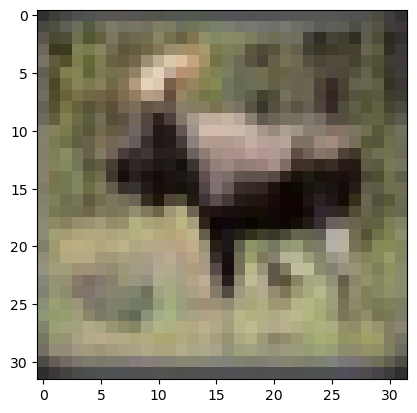

In [8]:
plt.imshow(x_train[16].astype('float32'));

In [9]:
#Importing Libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.layers import Resizing, Conv2D, MaxPooling2D, Flatten, Dense
from keras.datasets import cifar10
from keras.utils import to_categorical, set_random_seed

In [10]:
#copied code from above given by Prof James. 
# Set random seed for reproducibility
set_random_seed(0)

# Define subsample function
def subsample(X, y=None, p=0.1):
    n_samples = X.shape[0]
    subsample_size = int(n_samples * p)
    idxs = np.random.choice(n_samples, subsample_size, replace=False)
    if y is None:
        return X[idxs]
    else:
        return X[idxs], y[idxs]

In [11]:
#copied code from above given by Prof James.
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Subsample training data
x_train, y_train = subsample(x_train, y_train, 0.2)

# Convert data types and normalize
x_train = x_train.astype('float16') / 255.0
x_test = x_test.astype('float16') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [12]:
print('the shape of x_train data are', x_train.shape)
print('the shape of x_test data are', x_test.shape)
print('the shape of y_train data are', y_train.shape)
print('the shape of y_test data are', y_test.shape)

the shape of x_train data are (10000, 32, 32, 3)
the shape of x_test data are (10000, 32, 32, 3)
the shape of y_train data are (10000, 10)
the shape of y_test data are (10000, 10)


In [13]:
#Some of the lib already been used by Prof James and some added for modelling.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.layers import Resizing, Conv2D, MaxPooling2D, Flatten, Dense
from keras.datasets import cifar10
from keras.utils import to_categorical, set_random_seed

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras

from keras.layers import Resizing
from keras.datasets import cifar10
from keras.utils import to_categorical, set_random_seed
from keras import layers


from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras import layers
import numpy as np

# remove this cell before posting
from keras.applications import MobileNetV2
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, BatchNormalization, Activation, Dropout

## Basic Convolutional Neural Network (CNN)

This code constructs a basic convolutional neural network (CNN) for a given dataset with 32x32 pixel images. The CNN architecture consists of a single convolutional layer followed by a Dense layer with 2 neurons. Due to the shallow architecture and limited capacity, the model is expected to achieve low accuracy on complex classification tasks.

The CNN employs the ReLU activation function for the inner layer to introduce non-linearity and improve model capacity. The final layer utilizes the softmax activation function, which is suitable for multiclass classification problems like this one with 10 classes (one output neuron per class). The implementation is inspired by the Week 7 Jupyter notebook for the MNIST dataset and accompanying documentation.


In [14]:
#Initial basic model. Code written with refrence from MNSIT DS provided in week 7 also Keras MNSIT document.
input_shape = (32, 32, 3)
model = Sequential(
    [
      keras.Input(shape=input_shape),
      layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Flatten(),
      layers.Dropout(0.4),
      layers.Dense(2, activation='relu'),
      layers.Dense(10, activation='softmax')
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dropout (Dropout)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 2)                 14402     
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                      

In [15]:
history = model.fit(x_train, y_train, epochs=25, batch_size=16, validation_split=0.4, verbose=1)

Epoch 1/25


375/375 [==============================] - 4s 7ms/step - loss: 2.3026 - accuracy: 0.1030 - val_loss: 2.3030 - val_accuracy: 0.0938
Epoch 2/25
375/375 [==============================] - 2s 7ms/step - loss: 2.3023 - accuracy: 0.1003 - val_loss: 2.3035 - val_accuracy: 0.0938
Epoch 3/25
375/375 [==============================] - 2s 6ms/step - loss: 2.3022 - accuracy: 0.1068 - val_loss: 2.3037 - val_accuracy: 0.0938
Epoch 4/25
375/375 [==============================] - 2s 6ms/step - loss: 2.3022 - accuracy: 0.1068 - val_loss: 2.3040 - val_accuracy: 0.0938
Epoch 5/25
375/375 [==============================] - 2s 6ms/step - loss: 2.3022 - accuracy: 0.1068 - val_loss: 2.3039 - val_accuracy: 0.0938
Epoch 6/25
375/375 [==============================] - 2s 7ms/step - loss: 2.3022 - accuracy: 0.1020 - val_loss: 2.3041 - val_accuracy: 0.0938
Epoch 7/25
375/375 [==============================] - 2s 6ms/step - loss: 2.3022 - accuracy: 0.1048 - val_loss: 2.3042 - val_accuracy: 0.0938
Epoc

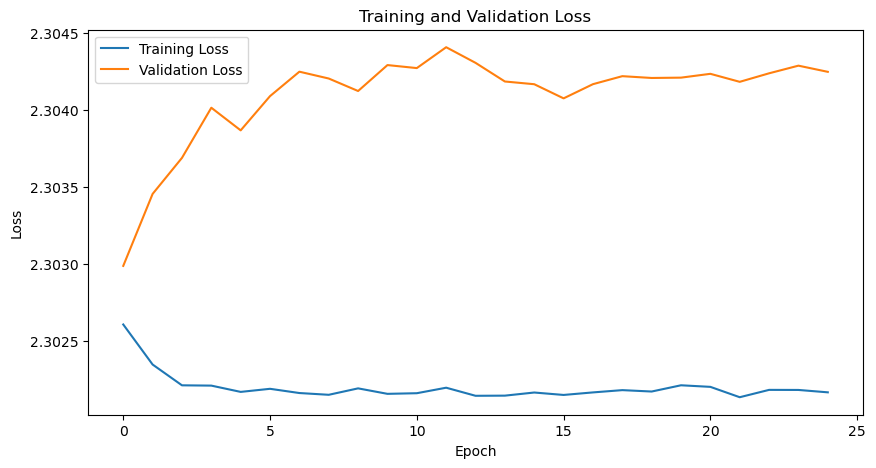

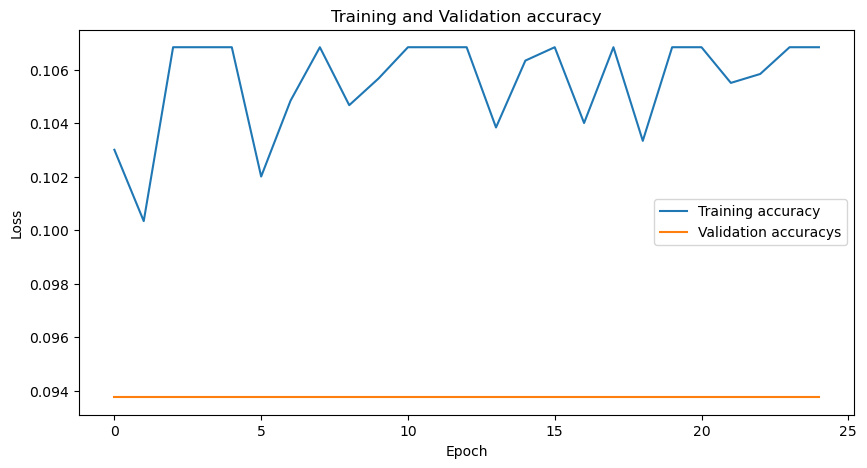

In [16]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracys')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Analysis of Training and Validation Performance

An examination of the validation and accuracy loss graphs, along with trends observed in training and validation accuracy around epoch 15, suggests minimal change in both loss functions beyond this point. Validation accuracy exhibits a consistent trajectory, indicating limited variation. While some variability exists in training accuracy, it primarily fluctuates within a narrow range, typically between 0.102 and 0.106.

Therefore, training for approximately 15 epochs appears sufficient. However, it's important to note the achieved accuracy is relatively low. This can likely be attributed to the limitation imposed by a Dense layer set to a value of 2, creating a bottleneck for a multi-classification CNN problem.

313/313 [==============================] - 1s 3ms/step


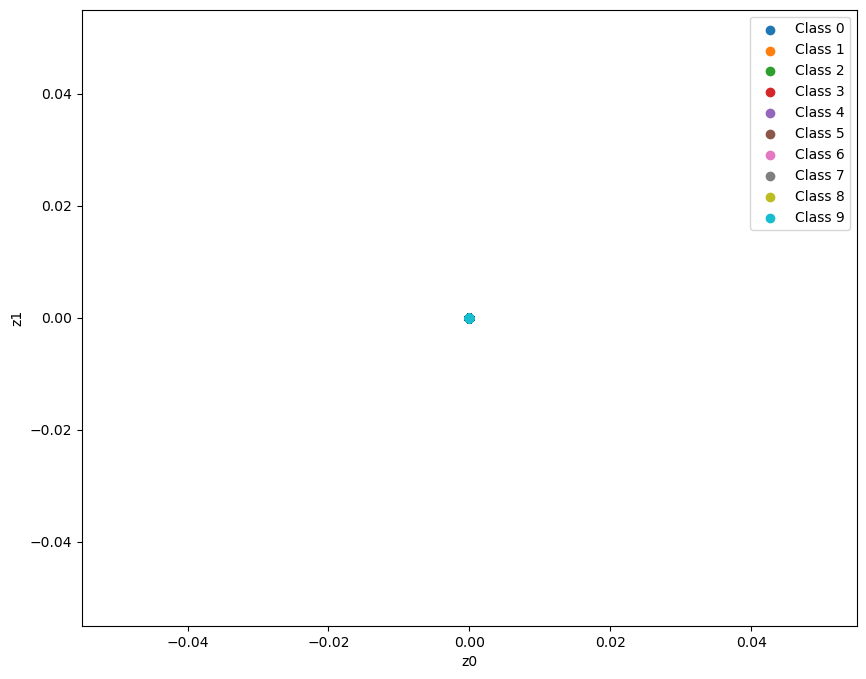

In [24]:
# Extract activations of the penultimate Dense(z) layer
penultimate_layer_output = Model(inputs=model.input, outputs=model.layers[-2].output)
z_output = penultimate_layer_output.predict(x_test)

# Visualize the embedding using the visualise_embedding function
visualise_embedding(z_output, y_test)


The limited capacity imposed by a small Dense layer, specifically set to a dimension of 2, restricts the model's ability to effectively categorize images. Consequently, the model appears to be capable of distinguishing only a single image belonging to class 9 within the dataset. This constraint underscores the inadequacy of the model architecture in handling the complexities inherent in multi-classification tasks, thereby resulting in suboptimal performance.

## 1st Model

To explore the impact of different hyperparameters and image sizes, we are creating a series of models, each with varying configurations. The first model will have an image size of 64 pixels and will incorporate two convolutional layers. Max pooling will be applied across all models to facilitate the extraction of salient features from the input data.

For consistency across all models, we will utilize softmax activation in the output layer, as the task involves multiclass classification. Additionally, we opt for the Adam optimizer due to its adaptive learning rate characteristics, which enhance convergence efficiency compared to traditional stochastic gradient descent methods.

As for the loss function, categorical cross-entropy is chosen as it suits multi-class classification tasks with one-hot encoded targets. This loss function quantifies the discrepancy between the predicted probability distribution and the true distribution of the target classes, thereby guiding the model towards better classification performance.

In [25]:
# some pretrained models require a specific image *size*.
# if needed, we can use code like this to make a resized version of the images

resizing_layer = Resizing(64, 64) # a resizing layer can work on its own, doesn't have to be part of a model
x_train_64px = resizing_layer(x_train)
x_test_64px = resizing_layer(x_test)

In [26]:

input_shape = (64, 64, 3)
# Build the model
model_64px = Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3)),

        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Flatten(),
        layers.Dropout(0.3),   
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
      ])

# Compile the model
model_64px.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_64px.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 5184)              0         
                                                                 
 dropout_1 (Dropout)         (None, 5184)             

In [28]:
history_64px = model_64px.fit(x_train_64px, y_train, epochs=5, batch_size=16, validation_split=0.4, verbose=1)



Epoch 1/5
375/375 [==============================] - 7s 18ms/step - loss: 1.5827 - accuracy: 0.4310 - val_loss: 1.5687 - val_accuracy: 0.4395
Epoch 2/5
375/375 [==============================] - 7s 19ms/step - loss: 1.4283 - accuracy: 0.4853 - val_loss: 1.4438 - val_accuracy: 0.4818
Epoch 3/5
375/375 [==============================] - 7s 20ms/step - loss: 1.2864 - accuracy: 0.5372 - val_loss: 1.3964 - val_accuracy: 0.5023
Epoch 4/5
375/375 [==============================] - 7s 19ms/step - loss: 1.1923 - accuracy: 0.5807 - val_loss: 1.3264 - val_accuracy: 0.5422
Epoch 5/5
375/375 [==============================] - 7s 20ms/step - loss: 1.1028 - accuracy: 0.6102 - val_loss: 1.3462 - val_accuracy: 0.5378


313/313 [==============================] - 3s 8ms/step


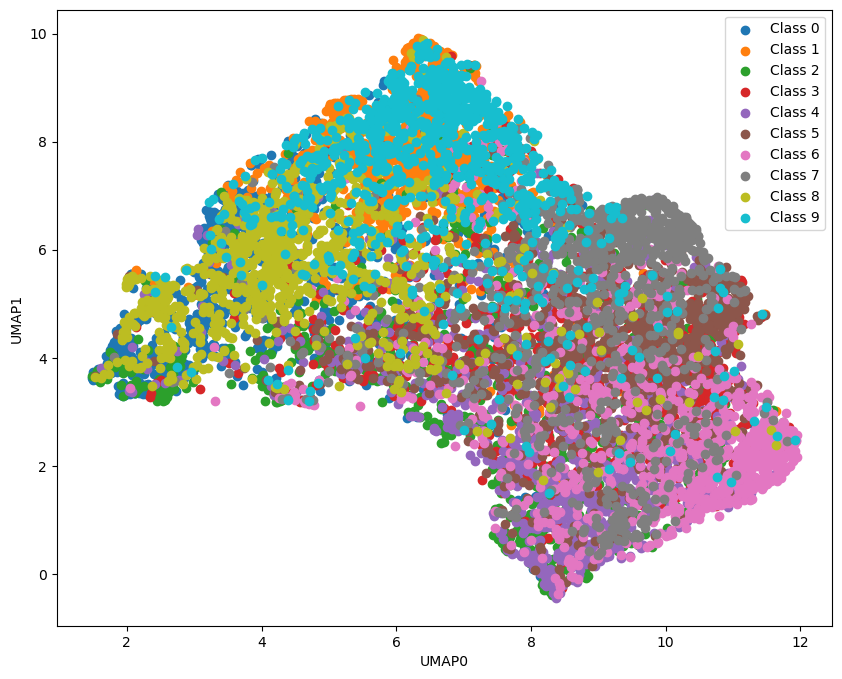

In [38]:
# Extract activations of the penultimate Dense(z) layer
penultimate_layer_output = Model(inputs=model_64px.input, outputs=model_64px.layers[-2].output)
z_output = penultimate_layer_output.predict(x_test_64px)

# Visualize the embedding using the visualise_embedding function
visualise_embedding(z_output, y_test)

Based on an initial assessment, employing 15 epochs for training appears to be adequate for this set of hyperparameters. The observed accuracy does not surpass the 57% mark within this timeframe.

Upon preliminary examination, the model demonstrates capability in distinguishing images from classes 9, 8, and 6. However, it exhibits confusion between certain pairs of classes, namely (9 and 1), (6 and 3), and (8 and 0). This suggests that the model is encountering challenges in discerning distinguishing features between these classes, leading to misclassifications.



## Model 2


In the second model iteration, we will adjust the image size to 16 pixels, necessitating the use of smaller kernel sizes to effectively operate on the reduced pixel space. Similar to the first model, this iteration will consist of two convolutional layers with identical kernel and pooling sizes.

Despite the lower resolution and pixel size of the input images, we aim to enhance feature extraction by employing 32 and 64 feature detection neurons in the respective layers. This approach allows for the capture of diverse and complex patterns within the constrained input space.

To maintain consistency and facilitate comparison with the first model, we will retain the same activation function and optimization settings. Specifically, the ReLU activation function will be used for the convolutional layers, while the Adam optimizer will continue to be employed for its adaptive learning rate properties.

In [40]:
# some pretrained models require a specific image *size*.
# if needed, we can use code like this to make a resized version of the images

resizing_layer = Resizing(16, 16) # a resizing layer can work on its own, doesn't have to be part of a model
x_train_16px = resizing_layer(x_train)
x_test_16px = resizing_layer(x_test)

In [41]:
input_shape = (16, 16, 3)
# Build the model
model_16px = Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),


        layers.Flatten(),
        layers.Dropout(0.1),   
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='softmax')
      ])

# Compile the model
model_16px.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_16px.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 64)          18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In the second model iteration, we will extend the training duration by increasing the number of epochs to 50. Given the lower pixel size, the computational overhead associated with training is expected to remain manageable, ensuring efficient training processes.

By extending the training duration, we aim to assess whether additional epochs yield discernible improvements in model performance, particularly in terms of reducing validation loss and enhancing accuracy. While higher epoch counts might lead to overfitting in certain scenarios, the constrained input space of the lower-resolution images mitigates this concern to some extent.

Throughout the training process, we will monitor the evolution of validation loss and accuracy metrics to ascertain whether further epochs result in diminishing returns or continued performance gains. This systematic evaluation will provide insights into the optimal training duration for achieving satisfactory model performance within the constraints of the given task and dataset.

In [42]:
history_16px = model_16px.fit(x_train_16px, y_train, epochs=50, batch_size=32, validation_split=0.5, verbose=1)

Epoch 1/50
157/157 [==============================] - 2s 8ms/step - loss: 2.1769 - accuracy: 0.1922 - val_loss: 2.0180 - val_accuracy: 0.2640
Epoch 2/50
157/157 [==============================] - 1s 8ms/step - loss: 1.9136 - accuracy: 0.2832 - val_loss: 1.8292 - val_accuracy: 0.3344
Epoch 3/50
157/157 [==============================] - 1s 8ms/step - loss: 1.7526 - accuracy: 0.3538 - val_loss: 1.7414 - val_accuracy: 0.3494
Epoch 4/50
157/157 [==============================] - 1s 8ms/step - loss: 1.6574 - accuracy: 0.3892 - val_loss: 1.6721 - val_accuracy: 0.3858
Epoch 5/50
157/157 [==============================] - 1s 8ms/step - loss: 1.5871 - accuracy: 0.4224 - val_loss: 1.6126 - val_accuracy: 0.4040
Epoch 6/50
157/157 [==============================] - 1s 8ms/step - loss: 1.5356 - accuracy: 0.4384 - val_loss: 1.6043 - val_accuracy: 0.4174
Epoch 7/50
157/157 [==============================] - 1s 8ms/step - loss: 1.4848 - accuracy: 0.4572 - val_loss: 1.5595 - val_accuracy: 0.4272
Epoch 

313/313 [==============================] - 1s 2ms/step


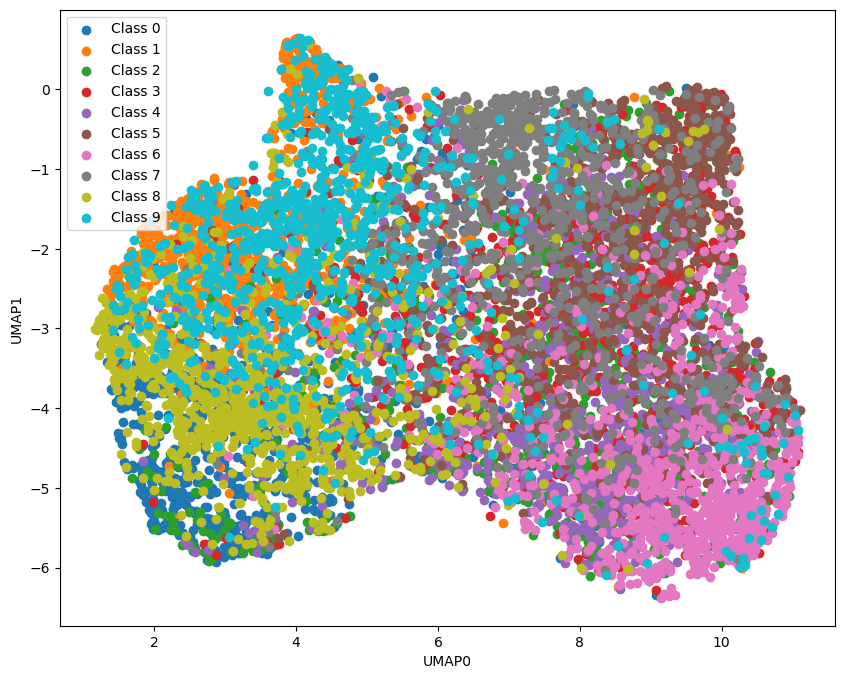

In [48]:
# Extract activations of the penultimate Dense(z) layer
penultimate_layer_output = Model(inputs=model_16px.input, outputs=model_16px.layers[-2].output)
z_output = penultimate_layer_output.predict(x_test_16px)

# Visualize the embedding using the visualise_embedding function
visualise_embedding(z_output, y_test)

Upon training the second model for an extended duration of 50 epochs, it becomes apparent that the accuracy plateaus after a certain point, with no significant improvement observed beyond a specific epoch count. This suggests that further training epochs do not yield discernible enhancements in accuracy.

Moreover, the utilization of lower-resolution images with reduced pixel size appears to adversely affect feature detection capabilities, resulting in diminished accuracy compared to models trained on higher-resolution images. The model's ability to differentiate between classes appears limited, with clear distinctions observed primarily between classes 9 and 6.

Visualizations of the model's performance reveal a tendency to detect common features across multiple classes, potentially contributing to classification errors. Consequently, despite prolonged training and evaluation, the model's accuracy remains constrained, typically reaching a maximum of 50% to 52%.

These findings underscore the inherent limitations associated with lower-resolution images and emphasize the importance of adequate feature representation for achieving optimal classification performance. Further investigations and potential adjustments to the model architecture or training strategy may be warranted to address these challenges effectively.

## Model 3

For the final model iteration, we aim to conduct experiments by varying kernel size, the number of layers, and filter size. This exploration is intended to assess the impact of these architectural parameters on model performance, particularly in terms of accuracy.

In this iteration, we will also adjust the architecture by incorporating changes to the number of layers and filters. Specifically, we will experiment with different configurations to determine if increasing the number of layers and filters contributes to improved accuracy.

Additionally, the final model will feature a dense layer with 256 neurons and a dropout rate of approximately 50%. This modification is intended to enhance the model's learning capabilities by selectively retaining valuable information from a subset of neurons during training.

By systematically exploring these variations and observing their effects on model performance, we aim to identify the optimal architectural configuration that maximizes classification accuracy while maintaining model efficiency and generalization ability.

In [72]:
input_shape = (32, 32, 3)
model_alt = Sequential(
    [
      keras.Input(shape=input_shape),
      layers.Conv2D(32, kernel_size=(4,4), activation='relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Conv2D(128, kernel_size=(2,2), activation='relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(256, activation='relu'),
      layers.Dense(10, activation='softmax')
    ]
)

model_alt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_alt.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 5, 5, 128)         32896     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 2, 2, 128)       

In [73]:
history_new = model_alt.fit(x_train, y_train, epochs=10, batch_size=16, validation_split=0.5, verbose=1)

Epoch 1/10
313/313 [==============================] - 8s 21ms/step - loss: 2.1294 - accuracy: 0.1926 - val_loss: 1.9918 - val_accuracy: 0.2572
Epoch 2/10
313/313 [==============================] - 7s 22ms/step - loss: 1.8589 - accuracy: 0.3060 - val_loss: 1.7251 - val_accuracy: 0.3458
Epoch 3/10
313/313 [==============================] - 7s 23ms/step - loss: 1.7104 - accuracy: 0.3530 - val_loss: 1.6904 - val_accuracy: 0.3712
Epoch 4/10
313/313 [==============================] - 6s 21ms/step - loss: 1.6221 - accuracy: 0.3976 - val_loss: 1.6132 - val_accuracy: 0.4224
Epoch 5/10
313/313 [==============================] - 7s 21ms/step - loss: 1.5659 - accuracy: 0.4156 - val_loss: 1.5720 - val_accuracy: 0.4120
Epoch 6/10
313/313 [==============================] - 6s 19ms/step - loss: 1.5100 - accuracy: 0.4464 - val_loss: 1.5047 - val_accuracy: 0.4462
Epoch 7/10
313/313 [==============================] - 6s 21ms/step - loss: 1.4601 - accuracy: 0.4540 - val_loss: 1.5244 - val_accuracy: 0.4350

313/313 [==============================] - 2s 7ms/step


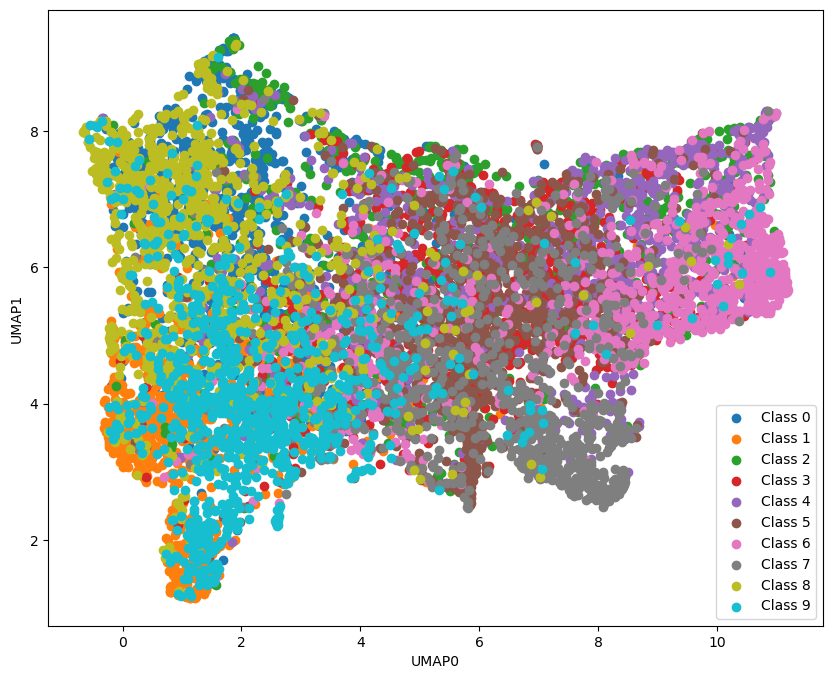

In [74]:
# Extract activations of the penultimate Dense(z) layer
penultimate_layer_output = Model(inputs=model_alt.input, outputs=model_alt.layers[-2].output)
z_output = penultimate_layer_output.predict(x_test)

# Visualize the embedding using the visualise_embedding function
visualise_embedding(z_output, y_test)

The final model's performance closely resembles that of the initial model, albeit with a slight reduction in accuracy, reaching a maximum of 48%. Despite modifications to the architecture, including adjustments to kernel size, the number of layers, and the incorporation of a dense layer with 256 neurons and a dropout rate of approximately 50%, the observed accuracy remains largely consistent with the baseline model.

This outcome suggests that the introduced architectural variations did not significantly impact model performance. The marginal decrease in accuracy underscores the challenges inherent in optimizing model architecture to improve classification accuracy while balancing complexity and computational efficiency.

Further analysis and potential refinements may be necessary to elucidate the underlying factors contributing to the observed outcomes and to iteratively enhance model performance.

## We are going to use Xception as our pretrained model due to the following reasons:

 ### Xception excels in image classification due to:
 - Efficient Depthwise Separable Convolutions: Reduced parameters for faster training and lower computational needs.
 - Extreme Depth with Feature Learning: Enables capturing intricate data patterns.
 - Improved Generalizability: Promotes learning transferable features for better unseen data performance.
 - State-of-the-Art Performance: Achieves high accuracy, making it practical for real-world applications.

 Xception's innovative design and strong generalization capabilities make it a top choice for many image classification tasks, although the optimal model depends on project specifics.

 Reference: [Towards Data Science - Review: Xception with Depthwise Separable Convolution](https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568)


Based on the analysis conducted during model training, it was observed that the pixel size of the input images significantly influences the accuracy of the model's performance. In light of this, a decision has been made to resize the image pixel to 160 pixels for the subsequent model iterations. This adjustment strikes a balance between computational efficiency and model performance, as higher pixel sizes can result in longer training times and increased computational complexity.

Given the limitations in computational capacity, particularly in training Xception models on higher pixel sizes, the number of epochs has been conservatively set to 10. This decision aims to mitigate the computational demands associated with training on larger pixel sizes while still allowing for meaningful analysis of model performance.

Preliminary findings indicate promising results, with the model achieving its highest accuracy of 77%. However, due to resource constraints, visualization of the training process was not feasible, necessitating reliance solely on numerical metrics for performance evaluation.

In [50]:
resizing_layer = Resizing(160, 160) # a resizing layer can work on its own, doesn't have to be part of a model
x_train_160px = resizing_layer(x_train)
x_test_160px = resizing_layer(x_test)

In [53]:
from keras.applications import Xception
#Xception model pretrained on ImageNet
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

83683744/83683744 [==============================] - 4s 0us/step


In [52]:
# Freeze the layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

In [55]:
# Add a new classification head suitable for the task
output = pretrained_model.layers[-1].output
output = MaxPooling2D(pool_size=(3, 3))(output)
output = Flatten()(output)
output = Dense(256, activation='relu')(output)
output = Dense(10, activation='softmax')(output)



In [56]:

# Create a new model with the modified output
model_pretrained = Model(inputs=pretrained_model.input, outputs=output)

In [57]:
model_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pretrained.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 79, 79, 32)           864       ['input_7[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 79, 79, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 79, 79, 32)           0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, 20, 20, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 20, 20, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 20, 20, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_9 

                                                                                                  
 block7_sepconv1 (Separable  (None, 10, 10, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 10, 10, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 10, 10, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 10, 10, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 10, 10, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 10, 10, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 10, 10, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 10, 10, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 10, 10, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 10, 10, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [58]:
history_existing = model_pretrained.fit(x_train_160px, y_train, epochs=10, batch_size=16, validation_split=0.5, verbose=1)

Epoch 1/10
313/313 [==============================] - 1619s 5s/step - loss: 1.3331 - accuracy: 0.5664 - val_loss: 1.0904 - val_accuracy: 0.6436
Epoch 2/10
313/313 [==============================] - 1560s 5s/step - loss: 0.7774 - accuracy: 0.7524 - val_loss: 0.9852 - val_accuracy: 0.7118
Epoch 3/10
313/313 [==============================] - 1562s 5s/step - loss: 0.5898 - accuracy: 0.8126 - val_loss: 1.5526 - val_accuracy: 0.6702
Epoch 4/10
313/313 [==============================] - 1416s 5s/step - loss: 0.4756 - accuracy: 0.8492 - val_loss: 1.1165 - val_accuracy: 0.7006
Epoch 5/10
313/313 [==============================] - 1404s 4s/step - loss: 0.3577 - accuracy: 0.8856 - val_loss: 0.9239 - val_accuracy: 0.7346
Epoch 6/10
313/313 [==============================] - 1405s 4s/step - loss: 0.2994 - accuracy: 0.9026 - val_loss: 0.8911 - val_accuracy: 0.7668
Epoch 7/10
313/313 [==============================] - 1490s 5s/step - loss: 0.2546 - accuracy: 0.9194 - val_loss: 1.0176 - val_accuracy:

Unfortunately, visualization of the training process was hindered by resource limitations, specifically running out of memory due to the constraints of our computing capacity. As a result, we were unable to generate visual representations of the model training dynamics and performance metrics.

This limitation underscores the challenges posed by restricted computational resources and emphasizes the need for careful resource management and optimization strategies during model development and experimentation. Despite the absence of visual insights, thorough analysis based on numerical metrics remains essential for evaluating model performance and guiding decision-making processes.

In [59]:
# Extract activations of the penultimate Dense(z) layer
penultimate_layer_output = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[-2].output)
z_output = penultimate_layer_output.predict(x_test_160px)

# # Visualize the embedding using the visualise_embedding function
# visualise_embedding(z_output, y_test, p_subsample=0.1)

#z_output = penultimate_layer_output.predict(x_test_160px, batch_size=32)

# Randomly select a subset of samples
subset_indices = np.random.choice(len(x_test_160px), size=int(0.1 * len(x_test_160px)), replace=False)
x_test_subset = x_test_160px[subset_indices]

z_output = penultimate_layer_output.predict(x_test_subset)

313/313 [==============================] - 344s 1s/step


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ 785, 8012, 4415, 3509, 1012, 2819, 6353, 8264, 3281, 2059, 4744,
       2480, 5616, 6183, 4271, 2199, 3082, 1473, 7263, 9859, 6086, 4743,
       1636,  685, 3333, 7097,  175, 3705, 2918, 6060, 1370, 8148, 9762,
       4860, 4542, 4663, 3234,  904, 8567, 9750,  570, 4630, 3972, 7661,
       1960,  846, 6566, 2837, 9871, 6535,  764, 1507, 8017, 5498, 9586,
       2802, 1067, 7266, 9287, 8309, 9260, 5872,  271, 7459, 6088, 6397,
       4169, 5603, 1329, 8118,  628, 6327, 9610, 3833, 7612, 2046, 8684,
       7196, 3982,  154, 3012,  120, 3271, 1826, 1864, 5030, 7645, 7429,
       9825, 1872,  118, 8908, 5606, 6776, 5754, 3247, 5420, 6451, 6834,
       4636, 3973, 3392, 6057, 7102, 5495, 7148, 9945, 2075, 3220, 1257,
       2762, 5974, 5314, 5226,   98, 5143, 8690, 7637, 6059, 1754, 5762,
       9040, 3588, 1149, 6948, 9254, 7735, 2005, 5406, 2810, 7402, 8014,
       8952, 4864,  712, 7260, 5275, 2154, 3449, 6751, 7855, 6511, 1094,
       5313, 1429, 3468, 5860, 9772, 9240, 5127,  965, 5317, 9656, 3937,
       3912, 9743, 5760, 9373, 3658, 1009, 2872, 9293, 2996, 1309, 7345,
       9531, 1678, 8080, 7919, 3836, 5716, 3687, 2223, 1838,   90, 9147,
       6350, 9115, 4056, 7882, 6533, 2188, 8295, 8926, 4399, 3329, 8972,
       9704, 2193, 1418, 3066, 3499,  923, 3770, 8071, 5390, 3844,  580,
       5459, 6218, 3096, 6724, 7140, 6285, 6254,   97,  449, 7449, 9448,
       1241, 9781, 4294, 4237, 9654,  690, 7347, 7370, 3496, 6812, 7560,
       9642, 8403, 5568, 2920, 6026, 9835, 7047, 6752, 7759, 2293, 6715,
       4274, 6938,  826, 2625, 9555, 9749, 7194, 2461, 2144, 7037, 4172,
        424, 5870, 5251, 8455, 6851, 7835, 9696, 1387, 5248, 9554, 7498,
       5841, 5867, 4335, 1750, 9233, 8229, 7995, 6140, 3675, 1161, 5190,
       7277, 3494, 2535,  971, 8298, 4669, 2524, 9142, 7685, 1461, 6056,
       2332, 1300, 5640,  201, 1874, 4772, 9376, 2286, 2886, 4911,   54,
       1157, 1795, 5948, 7598, 4723, 1478, 6683, 8638, 2850, 9535, 7438,
       3886, 1712, 4444, 9878, 9185, 8441,  251, 9243, 6194, 5722, 7769,
       2131, 5416, 4204, 6998, 5098, 7837, 6794, 7052, 6906, 8232, 7515,
       3655, 5632, 9854, 3837,  243, 7832, 7953, 8054, 3896, 8996, 7369,
       2656, 7290, 4881, 8728, 3478, 4836, 9155, 4540, 3480, 8521, 8152,
       2068, 6440, 6062, 5364, 2498, 5687, 5169, 1807, 7186, 3074, 9367,
       4121, 6589, 9192, 1229, 2425, 1947, 6133, 8790, 5933, 8042, 6437,
       4186, 7844, 9863, 4423, 1500, 9280, 7317, 5451, 6316, 7131, 3653,
        650, 4167, 5133, 2501, 6156, 8834, 1465, 4165, 6673, 5155, 3846,
       2720, 8883, 9282, 5016, 7507, 5500, 5968, 6647, 5961, 1046, 5160,
       5796, 2803,  185, 6053, 4879, 9623, 5710, 7492, 3685, 2845, 9361,
       5351, 7931, 3132, 9615, 6705, 6253, 6634, 6349, 8938, 2734, 8064,
       6922, 8077, 3657, 5778,  569, 4852, 1667, 4350, 3592, 8539, 8074,
       7994, 1203,  756, 3906, 1059, 5888, 8845, 3642, 5757, 4847, 5196,
       9975, 4777, 7122, 5287, 5022, 4161, 3586,  692, 8519, 7432, 1771,
       4138, 3411,  945, 3740, 9413, 9137, 8715,  745, 9015, 7002, 4596,
       6090, 1975, 1970, 5930, 3662,  716, 9148, 2281, 7731, 1837, 4457,
       9180, 3071, 3845, 4078, 6637, 6920, 9217, 4299, 7913,  793, 2378,
       4786, 1392, 3617, 7992, 9917, 8253, 4856, 1021, 8861, 2818, 2282,
       1177, 3992, 4733, 6808, 6467, 9279, 6722, 9135, 3691, 6322, 3615,
       6460, 6800, 1550, 2965, 5893, 1733, 3668, 6672, 5559,  572, 1978,
       9998, 8940, 3139,  499, 4578, 6871, 7884, 1216, 1696, 4058, 3971,
       5346, 4539, 6128, 5455, 2450, 4807, 2511, 8348,  367, 9676, 5297,
       4771, 4594, 9857, 9035, 3769, 8645, 2222, 6874,  959, 8700, 6293,
       1415, 5801, 4094,  388, 3806, 2519, 1643, 2029, 2940,  174, 3207,
       3433, 3147, 1487, 5706, 8772,  589, 3766, 5491, 7793, 5442, 4015,
       9104,  316, 2483, 3341, 3226, 7244, 2426, 1470, 8184, 1893,  423,
       3608, 9461, 7902, 8196, 8909, 3195, 4791, 9338, 7036, 5864, 1781,
       9645,  213, 8436, 5641, 8373,  484, 4525, 3508, 8945,  956, 9181,
       9539,  557,  204, 6289, 3515, 7655, 2321, 6586, 3374, 7529, 6843,
        683, 6284, 6796, 2839, 9033, 8549, 7207, 9152, 3231, 6358, 8977,
       1416, 6206, 3255, 9742, 2395,  584, 1840, 4003, 6368, 5145, 8806,
       3820, 1908, 5937, 6606, 6577, 4969, 3609, 8228, 6080, 3839, 7690,
       2405, 4115, 6446, 8575, 9886, 7087,  778, 6282,   68, 1239, 6754,
       2882, 9368, 3301, 1922, 8461, 9414, 4821, 6003, 1966, 7224, 4439,
        219, 8445, 3821, 9496, 6428, 5677,  608, 2036, 1389, 5724, 5348,
       8219, 6245,  255,  958, 6130, 1166, 3048, 1745, 4492, 2889, 9210,
        706, 4845, 5761, 1699, 3356, 9595, 2183,  422, 9381, 3399, 7525,
       2717, 7537, 3216, 5429,  389, 5452, 3518, 7783, 1590,   86, 3075,
       6084, 7242, 3445, 2899, 3822, 3541, 4968, 1237, 2267, 1703,  978,
       5701, 2869, 2713, 2214, 3498, 1882, 3188, 6011, 5246, 7308, 1749,
       7646, 5934, 8168, 9739, 3635, 3035, 3378, 2911, 9055,  145, 9783,
       9022,  494, 4509, 2416, 1494, 1007, 7559, 4386, 6257, 3294, 1259,
       4402, 9884, 4283, 8721, 4796, 7643, 6344, 4374, 7540, 4133, 5116,
       1352, 2815, 3683, 6469, 1529, 1167, 4522, 6389, 7745, 4784, 8384,
       5393, 1379, 7798, 3603, 1051, 2588, 8518,  995, 8515, 8890, 8458,
       4153, 8430, 3755, 7634, 1854, 6122, 7440,  354, 4227, 6595,  736,
       1225, 4932, 8837,  599,  211, 1961, 2879, 4523, 1419,  266, 4065,
       4720, 8785, 6078, 5656, 8522,  315, 8492, 5422, 4103, 7259, 8842,
        941, 5602, 6052, 1763, 8305, 5943,   32, 9852, 7095, 6225, 9397,
       4937, 7588, 4456, 2716, 4008, 2362, 8692, 8447, 2672, 1290, 2433,
       3618, 5975, 7505, 7302, 8531, 4072,  188,  240, 1684, 6271, 2487,
       9385, 6119, 6036, 4549, 3155, 5034, 2166, 8349, 1995,  338, 8237,
       8351, 9641, 6988, 9814, 2550,  365,   72, 2413, 4726, 8158, 5746,
       7614, 7218, 8224, 9154, 3521, 2777, 8127, 5139, 6721, 5231, 2486,
       8892, 8109,  682, 3544,  337, 3241,  671, 3729, 8009, 8493, 6517,
        199, 6351, 8503, 3761, 1096, 6604, 7575, 2101, 7348, 7615, 4183,
       2655, 9497, 7039, 8817, 5947, 6822,  657, 1373, 8318, 5112,  524,
       8260, 8922, 7772, 1261, 9146,  286, 9868, 7463, 1255, 5029, 1025,
       6907, 2142, 7885, 7818, 2908, 7386, 9208, 9712, 2494, 6346, 7711,
       4950, 5234, 9542, 9117, 5264,  616, 6696, 1345, 2682,  168, 1752,
       3660, 2745, 3929, 8675, 1454, 9851, 3393, 7000, 9569, 6616, 2137,
       8078, 7193, 5540, 2768, 9809, 9472, 4749, 1233, 1361, 6487, 4118,
       9944, 7941, 9651, 1427, 2508, 9166, 9893, 4467, 6118, 7161, 9953,
       4328, 9637, 3582,  336, 5278, 6168,  194, 8699, 2597, 8550])